# GAN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
import torch
from fastai.vision.all import *
from fastai.vision.gan import *
from torch import nn
from torch.utils.data import Dataset
import random
import matplotlib.pyplot as plt
import torch.optim as optim
from fastai.optimizer import Adam



In [3]:
print(fastai.__version__) # version check

2.7.15


### Data

In [4]:
embedding = torch.load('embedding.pkl')

In [5]:
class Txt2ImgDataset(Dataset):
    def __init__(self, items, embedding=embedding):
        self.items = items
        self.embedding = embedding

    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        fn = self.items[idx]
        key = fn.name.split('.')[0] + '.txt'
        
        if key not in self.embedding:
            # Handle case where embedding for key is not found
            print(f"Embedding not found for key: {key}")
            return None
        
        emb = self.embedding[key]
        img = PILImage.create(fn).resize((128, 128))  # Ensure the image is resized to 128x128
        wrong_img = self.get_wrong_image(idx)
        noise = torch.randn(100, 1, 1)
        emb_with_noise = torch.cat([emb, noise], 0)
        return emb, tensor(img).permute(2, 0, 1).float() / 255.0, emb_with_noise, tensor(wrong_img).permute(2, 0, 1).float() / 255.0, fn.name

    def get_wrong_image(self, idx):
        cat = '_'.join(self.items[idx].name.split('_')[:-3])
        wrong_idx = random.choice(range(len(self.items)))
        while '_'.join(self.items[wrong_idx].name.split('_')[:-3]) == cat:
            wrong_idx = random.choice(range(len(self.items)))
        wrong_fn = self.items[wrong_idx]
        wrong_img = PILImage.create(wrong_fn).resize((128, 128))  # Ensure the wrong image is resized to 128x128
        return wrong_img


In [6]:
def verify_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        sample = dataset[idx]
        
        if sample is None:
            continue
        
        emb, img, emb_with_noise, wrong_img, img_name = sample
        
        print(f"Sample {i + 1} - Image: {img_name}")
        print(f"Embedding shape: {emb.shape}")
        print(f"Image shape: {img.shape}")
        print(f"Embedding with noise shape: {emb_with_noise.shape}")
        print(f"Wrong image shape: {wrong_img.shape}")
        
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img.permute(1, 2, 0))
        axs[0].set_title("Correct Image")
        axs[1].imshow(wrong_img.permute(1, 2, 0))
        axs[1].set_title("Wrong Image")
        plt.show()


In [7]:
### DataBlock and DataLoaders
def get_dls(path, bs):
    items = get_image_files(path)
    dset = Txt2ImgDataset(items)
    return DataLoaders.from_dsets(dset, dset, bs=bs)

dls = get_dls('data/images/train', bs=128)

Sample 1 - Image: Caspian_Tern_0045_145554_4.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


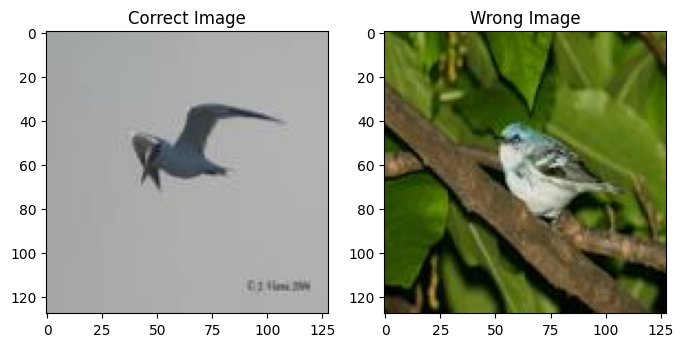

Sample 2 - Image: Blue_Headed_Vireo_0089_156062_3.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


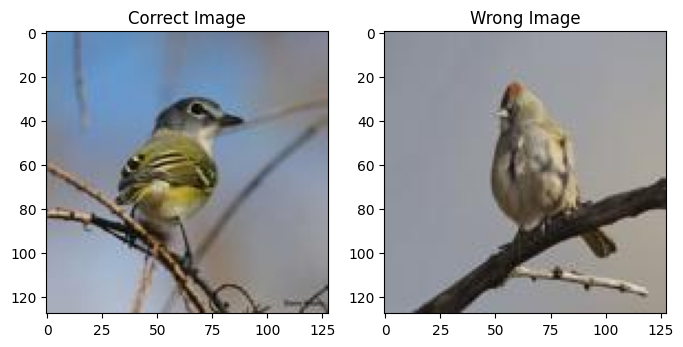

Sample 3 - Image: Northern_Fulmar_0064_43710_1.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


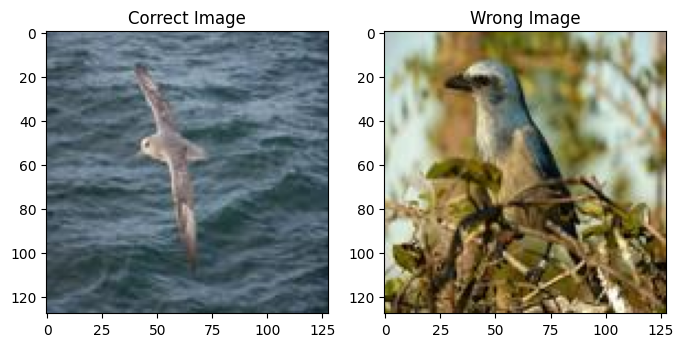

Sample 4 - Image: Laysan_Albatross_0100_735_2.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


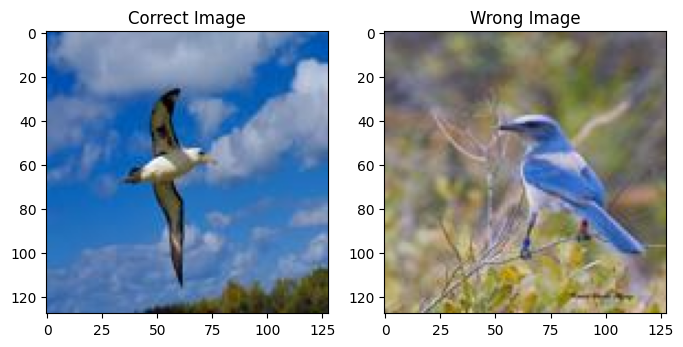

Sample 5 - Image: Fish_Crow_0051_25934_3.jpg
Embedding shape: torch.Size([400, 1, 1])
Image shape: torch.Size([3, 128, 128])
Embedding with noise shape: torch.Size([500, 1, 1])
Wrong image shape: torch.Size([3, 128, 128])


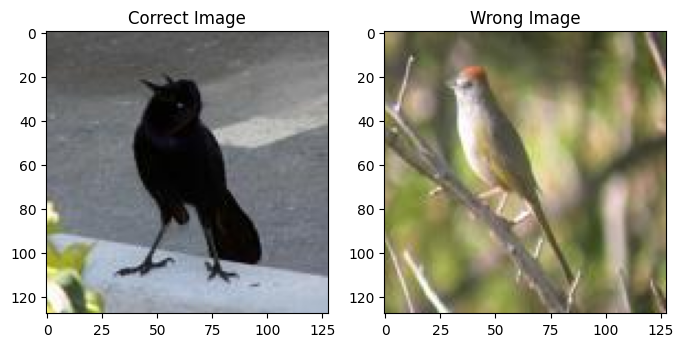

In [8]:
# Verify the dataset
verify_dataset(dls.train_ds, num_samples=5)

### GAN Model and Training

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim, emb_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim + emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(1024, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(True)
        )
        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z, emb):
        x = torch.cat([z, emb], dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 128, 16, 16)
        img = self.conv_blocks(x)
        return img


In [10]:
class Critic(nn.Module):
    def __init__(self, emb_dim):
        super(Critic, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 8 * 8 + emb_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, img, emb):
        x = self.conv_blocks(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, emb], dim=1)
        validity = self.fc(x)
        return validity


In [11]:
def gradient_penalty(critic, real_images, fake_images, embeddings):
    batch_size, c, h, w = real_images.shape
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    interpolated.requires_grad_(True)
    mixed_scores = critic(interpolated, embeddings)
    
    gradient = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradient = gradient.view(gradient.size(0), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1) ** 2)
    return penalty


In [12]:
class Txt2ImgLoss(GANModule):
    def __init__(self, gan_model, lambda_gp=10.0):
        super().__init__()
        self.gan_model = gan_model
        self.lambda_gp = lambda_gp

    def generator(self, output, *target):
        fake_pred = self.gan_model.critic(output[0], output[2])  # Pass embedding with noise
        return -fake_pred.mean()

    def critic(self, real_pred, *target):
        real_images, embeddings, real_img_pred = real_pred
        em_noise, wrong_img, *_ = target

        fake_images = self.gan_model.generator(em_noise)
        fake_pred = self.gan_model.critic(fake_images, embeddings)

        gp = gradient_penalty(self.gan_model.critic, real_images, fake_images, embeddings)
        return (fake_pred.mean() - real_img_pred.mean()) + self.lambda_gp * gp


In [13]:
class Txt2ImgGANTrainer(GANTrainer):
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        last_loss = last_loss.detach().cpu()
        if self.gen_mode:
            self.smoothenerG.add_value(last_loss)
            self.glosses.append(self.smoothenerG.smooth)
            self.last_gen = last_output[1].detach().cpu()
        else:
            self.smoothenerC.add_value(last_loss)
            self.closses.append(self.smoothenerC.smooth)


In [14]:
switcher = FixedGANSwitcher(n_crit=5, n_gen=1)

z_dim = 100
emb_dim = embedding[list(embedding.keys())[0]].shape[0] 
generator = Generator(z_dim, emb_dim)
critic = Critic(emb_dim)

gan = GANModule(generator, critic)
loss_func = Txt2ImgLoss(gan)

learn = Learner(dls, gan, loss_func=loss_func, 
                opt_func=Adam, wd=0., 
                cbs=[switcher], path='.')

trainer = Txt2ImgGANTrainer(learn, clip=0.01, show_img=True)
learn.gan_trainer = trainer
learn.add_cbs([trainer])

learn.fit(100, lr=1e-4)  # Adjust number of epochs as needed


/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that 

epoch,train_loss,valid_loss,time


/Users/devanshurana/Desktop/Projects/text2image-gan/.venv/lib/python3.12/site-packages/fastai/learner.py:448: SyntaxWarning: invalid escape sequence '\R'
  e.args = [f"Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:\n\t{e.args[0]}"]


TypeError: Critic.forward() missing 1 required positional argument: 'emb'